In [3]:
import os
os.environ['DYLD_LIBRARY_PATH'] = '/opt/homebrew/opt/openslide/lib:' + os.environ.get('DYLD_LIBRARY_PATH', '')


In [5]:
from PIL import Image
import openslide

# Replace this path with the path to your SVS file
svs_file_path = "/Users/yshokrollahi/Desktop/MD/Project2/dataset/2014-0938/Annotation/H&E/MS017_HE.svs"

# Open the SVS file using OpenSlide
svs_image = openslide.OpenSlide(svs_file_path)

# Get the size of the image at the highest resolution level
width, height = svs_image.dimensions

# Read the image at the highest resolution
# Note: This might require a lot of memory for large images
full_image = svs_image.read_region((0, 0), 0, (width, height))

# Convert to PIL image and remove the alpha channel
full_image = full_image.convert("RGB")

# Save the PNG file with a new name
png_file_path = svs_file_path.replace(".svs", "_fullsize.png")
full_image.save(png_file_path)

print(f"Conversion successful. New PNG file saved as: {png_file_path}")

Conversion successful. New PNG file saved as: /Users/yshokrollahi/Desktop/MD/Project2/dataset/2014-0938/Annotation/H&E/MS017_HE_fullsize.png


# Registration

In [12]:
import cv2
import pandas as pd
import numpy as np

# Load images
if_image = cv2.imread('/Users/yshokrollahi/Desktop/MD/Project2/dataset/2014-0938/Annotation/IF/MS017S1.png')
he_image = cv2.imread('/Users/yshokrollahi/Desktop/MD/Project2/dataset/2014-0938/Annotation/H&E/MS017_HE.png')

# Load landmarks
landmarks_IF = pd.read_csv('/Users/yshokrollahi/Desktop/MD/Project2/dataset/2014-0938/Annotation/Landmark/IF_output.csv')
landmarks_HE = pd.read_csv('/Users/yshokrollahi/Desktop/MD/Project2/dataset/2014-0938/Annotation/Landmark/HE_output.csv')

# Assuming landmarks file has columns named 'IF_x', 'IF_y', 'HE_x', 'HE_y'

# Extract landmark points
if_points = landmarks_IF[['CenterX', 'CenterY']].values
he_points = landmarks_HE[['CenterX', 'CenterY']].values

# Calculate transformation matrix
# Using an affine transformation as an example
transformation_matrix, _ = cv2.estimateAffine2D(he_points, if_points)

# Apply transformation
registered_he_image = cv2.warpAffine(he_image, transformation_matrix, (if_image.shape[1], if_image.shape[0]))

# Save the registered image
cv2.imwrite('/Users/yshokrollahi/Desktop/MD/Project2/dataset/2014-0938/Annotation/Registerd/100S_registered.png', registered_he_image)


True

# SSIM Calculation

In [10]:
import cv2
from skimage.metrics import structural_similarity as compare_ssim
import numpy as np

# Load the registered HE image and the reference IF image
registered_he_image = cv2.imread('/Users/yshokrollahi/Desktop/MD/Project2/dataset/2014-0938/Annotation/Registerd/registered.png')
if_image = cv2.imread('/Users/yshokrollahi/Desktop/MD/Project2/dataset/2014-0938/Annotation/IF/10.png')

# Convert both images to grayscale
registered_he_gray = cv2.cvtColor(registered_he_image, cv2.COLOR_BGR2GRAY)
if_gray = cv2.cvtColor(if_image, cv2.COLOR_BGR2GRAY)

# Ensure both images are the same size
if registered_he_gray.shape != if_gray.shape:
    # Resize or crop as necessary
    registered_he_gray = cv2.resize(registered_he_gray, (if_gray.shape[1], if_gray.shape[0]))

# Compute SSIM
ssim_index, _ = compare_ssim(registered_he_gray, if_gray, full=True)

print(f"SSIM: {ssim_index}")


SSIM: 0.6515229581048698


Fixed Image Size: (1130, 1899)
Moving Image Size: (1594, 1334)
SSIM after registration: 0.280888110163116


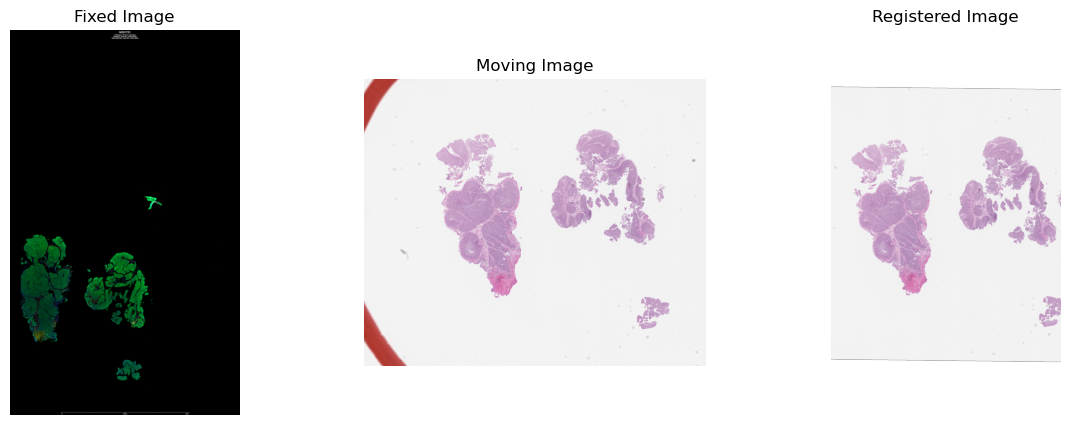

Registered image saved to: /Users/yshokrollahi/Desktop/MD/Project2/dataset/2014-0938/Annotation/Registerd/withoutregistered_image.png


In [7]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

def compute_ssim(image1, image2):
    """
    Compute the Structural Similarity Index (SSIM) between two images.
    """
    array1 = sitk.GetArrayFromImage(image1)
    array2 = sitk.GetArrayFromImage(image2)
    # Ensure the images are in the same shape
    if array1.shape != array2.shape:
        raise ValueError("Input images must have the same dimensions.")
    
    # Assuming the images are normalized between 0 and 1, set data_range to 1.
    # If your images have a different range, set it accordingly.
    data_range = array1.max() - array1.min()

    # Calculate SSIM
    ssim_value = ssim(array1, array2, data_range=data_range, multichannel=True)
    
    return ssim_value

def register_images(fixed_image_path, moving_image_path, output_path):
    # Read the images
    fixed_image_rgb = sitk.ReadImage(fixed_image_path, sitk.sitkVectorUInt8)
    moving_image_rgb = sitk.ReadImage(moving_image_path, sitk.sitkVectorUInt8)

    print(f"Fixed Image Size: {fixed_image_rgb.GetSize()}")
    print(f"Moving Image Size: {moving_image_rgb.GetSize()}")

    # Convert RGB to grayscale for registration
    fixed_image = sitk.VectorIndexSelectionCast(fixed_image_rgb, 0, sitk.sitkFloat32)
    moving_image = sitk.VectorIndexSelectionCast(moving_image_rgb, 0, sitk.sitkFloat32)

#     # Calculate SSIM before registration
#     ssim_before = compute_ssim(fixed_image, moving_image)
#     print(f"SSIM before registration: {ssim_before}")

    # Initialize the Image Registration Method
    registration_method = sitk.ImageRegistrationMethod()

    # Initialize the Transform (Affine)
    initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                          moving_image, 
                                                          sitk.AffineTransform(2), 
                                                          sitk.CenteredTransformInitializerFilter.GEOMETRY)

    registration_method.SetInitialTransform(initial_transform)

    # Similarity Metric Settings (Mutual Information)
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=10)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.3)

    registration_method.SetInterpolator(sitk.sitkLinear)

    # Optimizer Settings
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, 
                                                      numberOfIterations=1000, 
                                                      convergenceMinimumValue=1e-6, 
                                                      convergenceWindowSize=20)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Multi-resolution Framework
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[6, 4, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[4, 1, 0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Execute Registration
    final_transform = registration_method.Execute(fixed_image, moving_image)

    # Apply Transformation to RGB Image
    resampled_image_rgb = sitk.Resample(moving_image_rgb, 
                                        fixed_image_rgb, 
                                        final_transform, 
                                        sitk.sitkLinear, 
                                        0.0, 
                                        moving_image_rgb.GetPixelID())

    # Convert to grayscale for SSIM calculation after registration
    resampled_image = sitk.VectorIndexSelectionCast(resampled_image_rgb, 0, sitk.sitkFloat32)

    # Calculate SSIM after registration
    ssim_after = compute_ssim(fixed_image, resampled_image)
    print(f"SSIM after registration: {ssim_after}")
    
    # Display and save the results
    display_images_side_by_side(fixed_image_rgb, moving_image_rgb, resampled_image_rgb, titles=['Fixed Image', 'Moving Image', 'Registered Image'])
    sitk.WriteImage(resampled_image_rgb, output_path)
    print(f"Registered image saved to: {output_path}")

def display_images_side_by_side(*images, titles):
    number_of_images = len(images)
    fig, axs = plt.subplots(1, number_of_images, figsize=(5 * number_of_images, 5))
    for i, image in enumerate(images):
        array_image = sitk.GetArrayFromImage(image)
        axs[i].imshow(array_image, cmap='gray')
        axs[i].set_title(titles[i])
        axs[i].axis('off')
    plt.show()

# Define your paths and variables
if_full_image_path = '/Users/yshokrollahi/Desktop/MD/Project2/dataset/2014-0938/Annotation/IF/10.png'
he_full_image_path = '/Users/yshokrollahi/Desktop/MD/Project2/dataset/2014-0938/Annotation/H&E/10.png'
output_path = '/Users/yshokrollahi/Desktop/MD/Project2/dataset/2014-0938/Annotation/Registerd/withoutregistered_image.png'



# Perform registration
register_images(if_full_image_path, he_full_image_path, output_path)
